# Specific game attributes for May 5 pilot

In [1]:
%pylab inline
import scipy.stats as stats
import itertools
import pandas as pd
import networkx as nx
from lifelines import CoxTimeVaryingFitter
import json
from collections import Counter
from measure_experiment import *

import pprint
pp = pprint.PrettyPrinter(indent=4)

from sklearn.decomposition import PCA

Populating the interactive namespace from numpy and matplotlib


In [2]:
export_dir = "../../results-sensitive/pilot/20200507/"
players = []
with open(export_dir + 'players.jsonl', 'r') as f:
    for line in f:
        players.append(json.loads(line))

games = []
with open(export_dir + 'games.jsonl', 'r') as f:
    for line in f:
        games.append(json.loads(line))
        
treatments = []
with open(export_dir + 'treatments.jsonl', 'r') as f:
    for line in f:
        treatments.append(json.loads(line))

logs = []
with open(export_dir + 'player-logs.jsonl', 'r') as f:
    for line in f:
        entry = json.loads(line)
        entry['data'] = json.loads(entry['jsonData'])
        logs.append(entry)

# match games, players, treatments, and log info
loaded_games = []
for game in games:
    game['players'] = {pl['_id']:pl for pl in players if pl['_id'] in game['playerIds']}
    treatment = [t for t in treatments if t["_id"] == game['treatmentId']][0]
    game['gameSetupId'] = treatment['name']
    game['log'] = [l for l in logs if l['gameId'] == game['_id']]
    
    loaded_games.append(game)
    
for i, game in enumerate(loaded_games):
    print(i, game['createdAt'], game['gameSetupId'])

0 2020-05-04T20:25:48.663Z testBots
1 2020-05-05T18:10:44.030Z panel_1_matched_pair_exp_design6_matched_20200319_134546
2 2020-05-05T18:11:30.507Z panel_1_matched_pair_caveman_exp_design6_matched_20200319_134546
3 2020-05-06T18:13:27.831Z panel_2_matched_pair_exp_design6_matched_20200319_134546
4 2020-05-06T18:19:54.834Z panel_2_matched_pair_caveman_exp_design6_matched_20200319_134546
5 2020-05-07T16:21:41.220Z testBots
6 2020-05-07T17:20:47.582Z panel_3_matched_pair_caveman_exp_design6_matched_20200319_134546
7 2020-05-07T17:25:08.619Z panel_3_matched_pair_exp_design6_matched_20200319_134546


In [3]:
# select which games to process
# Game 1 was a test game, for practice

select = [7]
process_games = [loaded_games[i] for i in select]
for game in process_games:
    print(i, game['createdAt'], game['gameSetupId'])

7 2020-05-07T17:25:08.619Z panel_3_matched_pair_exp_design6_matched_20200319_134546


In [4]:
for player_id, player in game['players'].items():
    if 'workerId' in player['urlParams'].keys():
        player['name'] = player['urlParams']['workerId']
    else:
        player['name'] = player['id']

In [5]:
t_players = [pid for pid in list(game['players'].keys()) if game['players'][pid]['data.position'][0]=='t']
c_players = [pid for pid in list(game['players'].keys()) if game['players'][pid]['data.position'][0]=='c']

In [6]:
t_start = datetime.strptime(game['createdAt'], '%Y-%m-%dT%H:%M:%S.%fZ')

game_log = pd.DataFrame(game['log'])
game_log['logTime'] = game_log['createdAt'].apply(lambda s: datetime.strptime(s, '%Y-%m-%dT%H:%M:%S.%fZ'))
game_log['t'] = game_log['logTime'] - t_start
game_log

,_id,playerId,gameId,roundId,stageId,name,jsonData,createdAt,data,logTime,t
0,qddzpkMR3pEmgbaW7,b2hFxZoZw8T4gFvSS,acKghgvvb3kewvMd9,Gys3zEFE5vxNzQo6X,kCSMytSpRSbfmDm3m,navigation,"""Pageload""",2020-05-07T17:25:09.819Z,Pageload,2020-05-07 17:25:09.819,00:00:01.200000
1,rEjYWLL39drx7toyH,TvuTrTHpttZh84r8m,acKghgvvb3kewvMd9,Gys3zEFE5vxNzQo6X,kCSMytSpRSbfmDm3m,navigation,"""Pageload""",2020-05-07T17:25:09.907Z,Pageload,2020-05-07 17:25:09.907,00:00:01.288000
2,8bLk7oZtQZQYnnWuM,AkJwenYB2cg5tTmvi,acKghgvvb3kewvMd9,Gys3zEFE5vxNzQo6X,kCSMytSpRSbfmDm3m,navigation,"""Pageload""",2020-05-07T17:25:09.922Z,Pageload,2020-05-07 17:25:09.922,00:00:01.303000
3,zk9G4Jvo9uWJzLb4h,vz5gsysZxQJWXm9oE,acKghgvvb3kewvMd9,Gys3zEFE5vxNzQo6X,kCSMytSpRSbfmDm3m,navigation,"""Pageload""",2020-05-07T17:25:09.943Z,Pageload,2020-05-07 17:25:09.943,00:00:01.324000
4,uDu8tbrhXsPfaiag9,kXBxj2mMZSyRHTtAm,acKghgvvb3kewvMd9,Gys3zEFE5vxNzQo6X,kCSMytSpRSbfmDm3m,navigation,"""Pageload""",2020-05-07T17:25:09.960Z,Pageload,2020-05-07 17:25:09.960,00:00:01.341000
...,...,...,...,...,...,...,...,...,...,...,...
2424,NiGKpQnKR4uGe8hYv,X54KjxkKkYdMFK7XG,acKghgvvb3kewvMd9,Gys3zEFE5vxNzQo6X,kCSMytSpRSbfmDm3m,drop,"{""clue"":""tclue_4_11"",""source"":""xLMf28PEwBYa5o4...",2020-05-07T17:33:05.994Z,"{'clue': 'tclue_4_11', 'source': 'xLMf28PEwBYa...",2020-05-07 17:33:05.994,00:07:57.375000
2425,LyqRQ7TwX8awaTAcJ,vz5gsysZxQJWXm9oE,acKghgvvb3kewvMd9,Gys3zEFE5vxNzQo6X,kCSMytSpRSbfmDm3m,drop,"{""clue"":""tclue_10_12"",""source"":""promising_lead...",2020-05-07T17:33:06.751Z,"{'clue': 'tclue_10_12', 'source': 'promising_l...",2020-05-07 17:33:06.751,00:07:58.132000
2426,5Zvg7suyameSKiNx8,eeym7vojJezTC8uyD,acKghgvvb3kewvMd9,Gys3zEFE5vxNzQo6X,kCSMytSpRSbfmDm3m,pickup,"{""clue"":""tclue_2_8"",""source"":""jHtZRkyBur449Mhsb""}",2020-05-07T17:33:07.081Z,"{'clue': 'tclue_2_8', 'source': 'jHtZRkyBur449...",2020-05-07 17:33:07.081,00:07:58.462000
2427,8jg6nSxGXfeNJ2rrj,9ci6JND9sKBsiGFf4,acKghgvvb3kewvMd9,Gys3zEFE5vxNzQo6X,kCSMytSpRSbfmDm3m,pickup,"{""clue"":""tclue_8_13"",""source"":""Yud2XrwJiFc2fv2...",2020-05-07T17:33:07.864Z,"{'clue': 'tclue_8_13', 'source': 'Yud2XrwJiFc2...",2020-05-07 17:33:07.864,00:07:59.245000


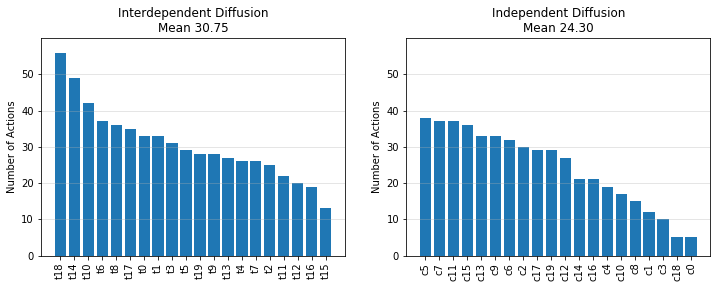

In [7]:
plt.figure(figsize=(12,4))

counts = game_log[game_log['name'] == 'drop'][['playerId', '_id']].groupby('playerId').count()

log_length = {}
for pid in t_players:
    player = game['players'][pid]
    if pid in counts.index:
        log_length[player['data.position']] = counts.loc[pid].values[0]
    else:
        log_length[player['data.position']] = 0
        
order = list(reversed(sorted(log_length.keys(), key=lambda x: log_length[x]))) 
plt.subplot(1,2,1)
plt.bar(order, [log_length[x] for x in order])
plt.xticks(rotation=90);
plt.ylim(0,60)
plt.yticks(range(0,60,10));
plt.grid('on', axis='y', alpha=.4)
plt.ylabel('Number of Actions')
plt.title('Interdependent Diffusion\nMean %.02f' % (np.mean(list(log_length.values()))));

log_length = {}
for pid in c_players:
    player = game['players'][pid]
    if pid in counts.index:
        log_length[player['data.position']] = counts.loc[pid].values[0]
    else:
        log_length[player['data.position']] = 0
        
order = list(reversed(sorted(log_length.keys(), key=lambda x: log_length[x]))) 
plt.subplot(1,2,2)
plt.bar(order, [log_length[x] for x in order])
plt.xticks(rotation=90);
plt.ylim(0,60)
plt.yticks(range(0,60,10));
plt.grid('on', axis='y', alpha=.4)
plt.ylabel('Number of Actions')
plt.title('Independent Diffusion\nMean %.02f' % (np.mean(list(log_length.values()))));

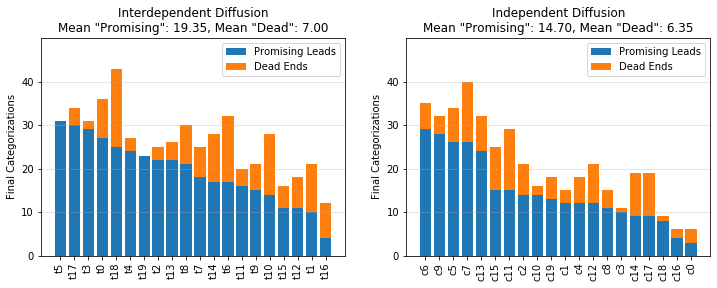

In [8]:
plt.figure(figsize=(12,4))

promising = {}
dead = {}
for pid in t_players:
    player = game['players'][pid]
    if 'data.notebooks' in player.keys():
        promising[player['data.position']] = len(player['data.notebooks']['promising_leads']['clueIDs'])
        dead[player['data.position']] = len(player['data.notebooks']['dead_ends']['clueIDs'])
    else:
        promising[player['data.position']] = 0
        dead[player['data.position']] = 0
        
order = list(reversed(sorted(promising.keys(), key=lambda x: promising[x])))
plt.subplot(1,2,1)
plt.bar(order, [promising[k] for k in order], label='Promising Leads')
plt.bar(order, [dead[k] for k in order], bottom=[promising[k] for k in order], label='Dead Ends')
plt.legend()
plt.xticks(rotation=90);
plt.ylim(0,50)
plt.yticks(range(0,50,10));
plt.grid('on', axis='y', alpha=.4)
plt.ylabel('Final Categorizations')
plt.title('Interdependent Diffusion\nMean "Promising": %.02f, Mean "Dead": %.02f' %(np.mean(list(promising.values())), np.mean(list(dead.values()))));


promising = {}
dead = {}
for pid in c_players:
    player = game['players'][pid]
    if 'data.notebooks' in player.keys():
        promising[player['data.position']] = len(player['data.notebooks']['promising_leads']['clueIDs'])
        dead[player['data.position']] = len(player['data.notebooks']['dead_ends']['clueIDs'])
    else:
        promising[player['data.position']] = 0
        dead[player['data.position']] = 0
        
order = list(reversed(sorted(promising.keys(), key=lambda x: promising[x])))
plt.subplot(1,2,2)
plt.bar(order, [promising[k] for k in order], label='Promising Leads')
plt.bar(order, [dead[k] for k in order], bottom=[promising[k] for k in order], label='Dead Ends')
plt.legend()
plt.xticks(rotation=90);
plt.ylim(0,50)
plt.yticks(range(0,50,10));
plt.grid('on', axis='y', alpha=.4)
plt.ylabel('Final Categorizations')
plt.title('Independent Diffusion\nMean "Promising": %.02f, Mean "Dead": %.02f' %(np.mean(list(promising.values())), np.mean(list(dead.values()))));

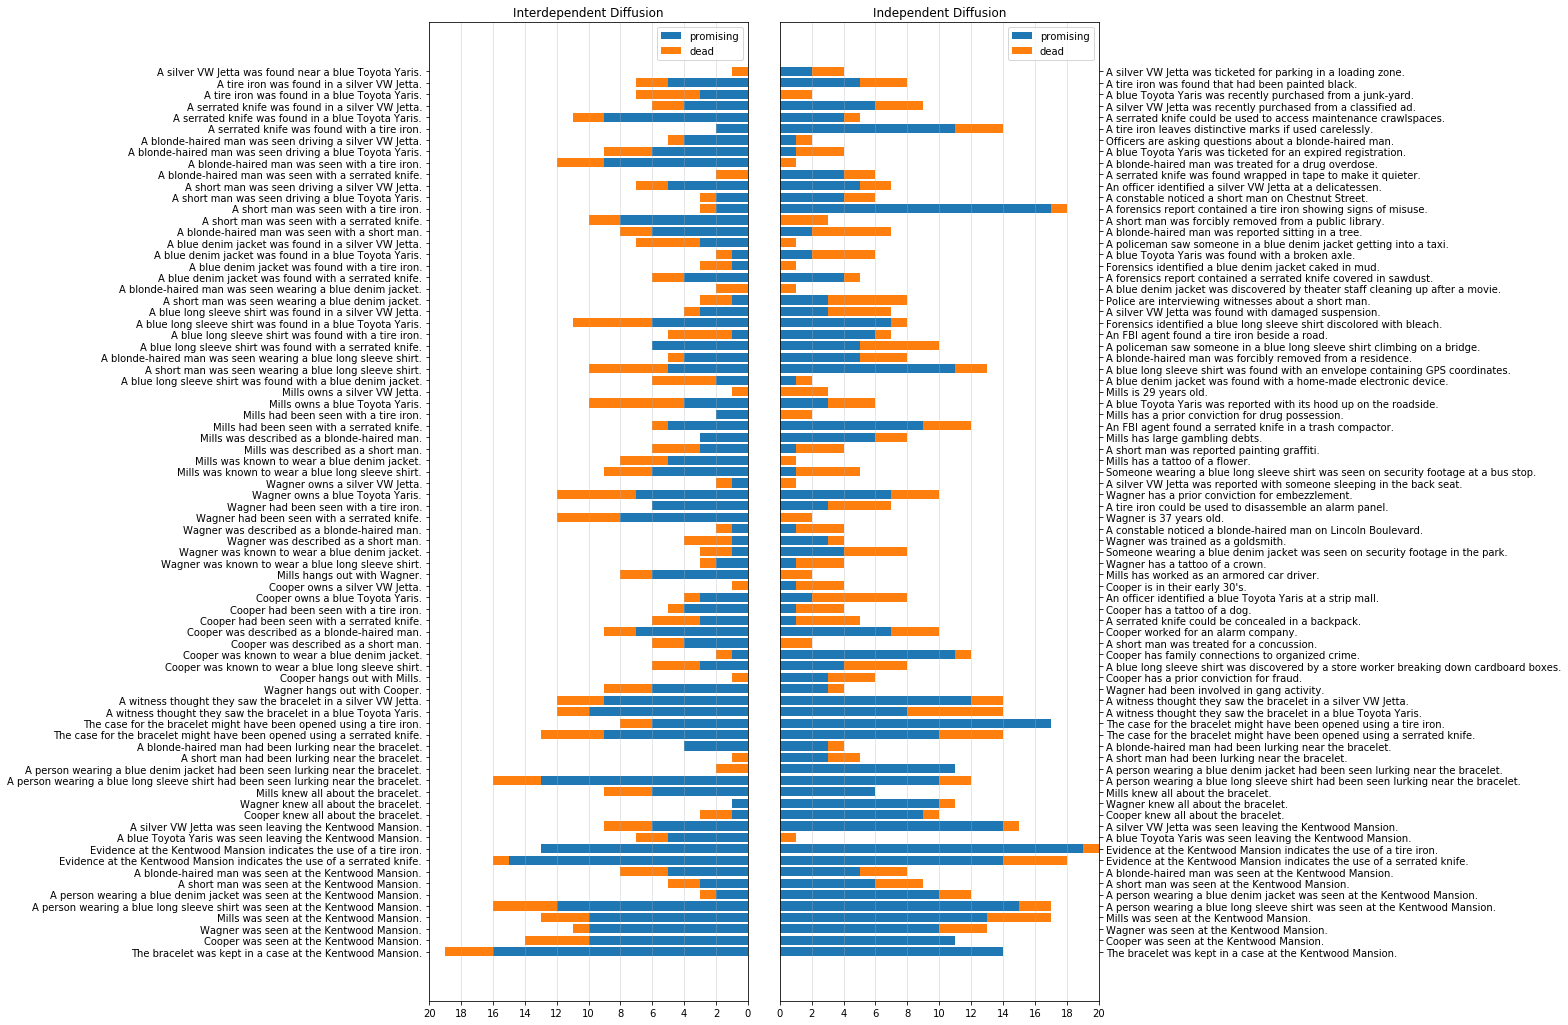

In [46]:

plt.figure(figsize=(12,18))

promising = Counter()
dead = Counter()
for pid in t_players:
    player = game['players'][pid]
    if 'data.notebooks' in player.keys():
        for clue_id in player['data.notebooks']['promising_leads']['clueIDs']:
            promising[clue_id] += 1
        for clue_id in player['data.notebooks']['dead_ends']['clueIDs']:
            dead[clue_id] += 1
            
axl = plt.subplot(1,2,1)       
#order = list(set(promising.keys()).union(set(dead.keys())))
order = [k for k in game['data.clues'].keys() if k[0]=='t']
plt.barh([game['data.clues'][clid]['content'] for clid in order], 
        [promising[k] for k in order], label='promising')
plt.barh([game['data.clues'][clid]['content'] for clid in order], 
        [dead[k] for k in order], left=[promising[k] for k in order], label='dead')
plt.legend()
plt.box('off')
plt.xlim(0,20)
plt.xticks(range(0,21,2));
plt.grid('on', axis='x', alpha=.4)
plt.title('Interdependent Diffusion');
axl.invert_xaxis()
inter_promising = promising
inter_order = order

promising = Counter()
dead = Counter()
for pid in c_players:
    player = game['players'][pid]
    if 'data.notebooks' in player.keys():
        for clue_id in player['data.notebooks']['promising_leads']['clueIDs']:
            promising[clue_id] += 1
        for clue_id in player['data.notebooks']['dead_ends']['clueIDs']:
            dead[clue_id] += 1

axr = plt.subplot(1,2,2)       
order = [k for k in game['data.clues'].keys() if k[0]=='c']
plt.barh([game['data.clues'][clid]['content'] for clid in order], 
         [promising[k] for k in order], label='promising')
plt.barh([game['data.clues'][clid]['content'] for clid in order], 
         [dead[k] for k in order], left=[promising[k] for k in order], label='dead')
plt.legend()
plt.xlim(0,20)
plt.xticks(range(0,21,2));
plt.box('off')
plt.grid('on', axis='x', alpha=.4)
plt.title('Independent Diffusion');
axr.yaxis.tick_right()
plt.subplots_adjust(wspace=.1)

indep_promising = promising
indep_order = order


In [47]:
spoke = [key for key in inter_promising.keys() if '_1_' in key or '_2_' in key]
nonspoke = [key for key in inter_promising.keys() if '_1_' not in key and '_2_' not in key]
print("Treatment: %.02f adoptions per spoke, %.02f adoptions per nonspoke" % 
      (np.sum([inter_promising[cl] for cl in spoke])/23, np.sum([inter_promising[cl] for cl in nonspoke])/55))

spoke = [key for key in indep_promising.keys() if '_1_' in key or '_2_' in key]
nonspoke = [key for key in indep_promising.keys() if '_1_' not in key and '_2_' not in key]
print("Control: %.02f adoptions per spoke, %.02f adoptions per nonspoke" % 
      (np.sum([indep_promising[cl] for cl in spoke])/23, np.sum([indep_promising[cl] for cl in nonspoke])/55))

Treatment: 7.22 adoptions per spoke, 3.53 adoptions per nonspoke
Control: 10.00 adoptions per spoke, 3.29 adoptions per nonspoke


3.989782869648269

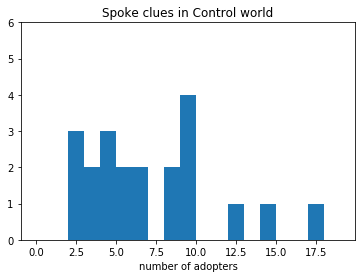

In [31]:
spoke = [key for key in indep_promising.keys() if '_1_' in key or '_2_' in key]
plt.hist([indep_promising[cl] for cl in spoke], bins=range(20))
plt.ylim(0,6)
plt.xlabel("number of adopters")
plt.title('Spoke clues in Control world')
#len(spoke)
#sum([indep_promising[cl] for cl in spoke])
np.std([indep_promising[cl] for cl in spoke])

3.8395810020714687

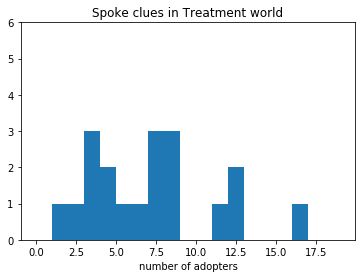

In [32]:
spoke = [key for key in inter_promising.keys() if '_1_' in key or '_2_' in key]
plt.hist([inter_promising[cl] for cl in spoke], bins=range(20))
plt.ylim(0,6)
plt.xlabel("number of adopters")
plt.title('Spoke clues in Treatment world')
#len(spoke)
#sum([inter_promising[cl] for cl in spoke])
np.std([inter_promising[cl] for cl in spoke])

# idle check

In [33]:
activity = {}
for player_id, player in game['players'].items():
    if 'data.active' in player.keys():
        activity[player['data.position']] = player['data.active']

activity


{'c12': 'idle once',
 'c7': 'idle once',
 't5': 'idle once',
 'c16': 'idle once',
 'c17': 'idle once',
 't8': 'idle once',
 'c5': 'idle once',
 't1': 'idle once',
 't19': 'idle once',
 'c13': 'idle once',
 'c18': 'idle once'}

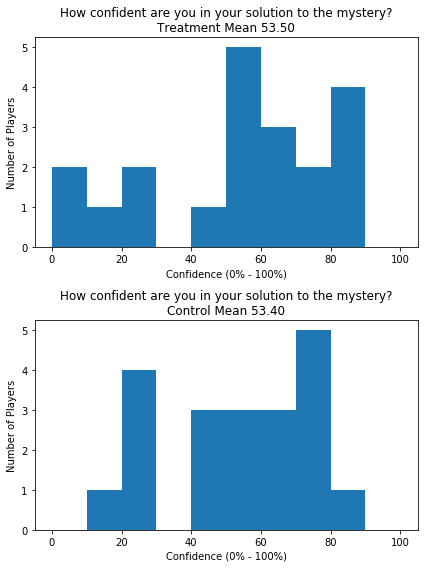

In [34]:
plt.figure(figsize=(6,8))

confidences = []
consensuses = []
for pid in t_players:
    player = game['players'][pid]
    if 'data.caseMade' in player.keys():
        confidences.append(player['data.caseMade']['confidence'])
plt.subplot(2,1,1)
plt.hist(confidences, bins=range(0,100,10))
np.mean(confidences), np.median(confidences)
plt.xlabel('Confidence (0% - 100%)')
plt.ylabel('Number of Players')
plt.title("How confident are you in your solution to the mystery?\nTreatment Mean %.02f"%np.mean(confidences))
plt.xlim(-5,105)

confidences = []
consensuses = []
for pid in c_players:
    player = game['players'][pid]
    if 'data.caseMade' in player.keys():
        confidences.append(player['data.caseMade']['confidence'])
plt.subplot(2,1,2)
plt.hist(confidences, bins=range(0,100,10))
np.mean(confidences), np.median(confidences)
plt.xlabel('Confidence (0% - 100%)')
plt.ylabel('Number of Players')
plt.title("How confident are you in your solution to the mystery?\nControl Mean %.02f"%np.mean(confidences))
plt.xlim(-5,105)
plt.tight_layout()
plt.savefig('confidence.png', transparent=True, dpi=500, bbox_inches='tight')



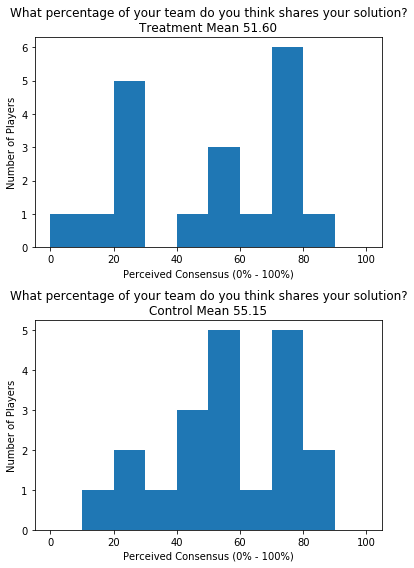

In [35]:
plt.figure(figsize=(6,8))


consensuses = []
for pid in t_players:
    player = game['players'][pid]
    if 'data.caseMade' in player.keys():
        consensuses.append(player['data.caseMade']['consensus'])
plt.subplot(2,1,1)
plt.hist(consensuses, bins=range(0,100,10))
plt.xlabel('Perceived Consensus (0% - 100%)')
plt.ylabel('Number of Players')
plt.title("What percentage of your team do you think shares your solution?\nTreatment Mean %.02f"%np.mean(consensuses))
plt.xlim(-5,105)


consensuses = []
for pid in c_players:
    player = game['players'][pid]
    if 'data.caseMade' in player.keys():
        consensuses.append(player['data.caseMade']['consensus'])
plt.subplot(2,1,2)
plt.hist(consensuses, bins=range(0,100,10))
plt.xlabel('Perceived Consensus (0% - 100%)')
plt.ylabel('Number of Players')
plt.title("What percentage of your team do you think shares your solution?\nControl Mean %.02f"%np.mean(consensuses))
plt.xlim(-5,105)
plt.tight_layout()
plt.savefig('consensus.png', transparent=True, dpi=500, bbox_inches='tight')


In [36]:
import string
fair = []
for player_id, player in game['players'].items():
    if 'data.survey' in player.keys():
        if 'fair' in player['data.survey'].keys():
            s = player['data.survey']['fair']
            fair.append(s.lower().translate(str.maketrans('', '', string.punctuation)))
            
counts = pd.Series(fair).value_counts()
pd.DataFrame(counts)


,0
yes,28
\nyes,1
it was fair,1
yes i think it was fair,1
if it had gone straight to the game than yes it would have been more than fair but because of all of the waiting in the lobby it is underpaid,1
yes,1
no,1
yes by mt standards it was extravagant,1
yes absolutely,1
the pay was fair,1


In [19]:
length = []
for player_id, player in game['players'].items():
    if 'data.survey' in player.keys():
        if 'time' in player['data.survey'].keys():
            s = player['data.survey']['time']
            length.append(s.lower().translate(str.maketrans('', '', string.punctuation)))
            
counts = pd.Series(length).value_counts()
pd.DataFrame(counts)

,0
yes,26
i think 10 minutes would have been more useful than 8,1
yeah,1
yep could have used more time on the clues but limiting it to 7 or 8 minutes was good enough,1
a little more time would have been nice,1
yes there was enough time to pay,1
yes,1
i think so it was hard to grasp even with practice,1
i think although no conclusion was definitively reached i do want to know the answer,1
no i felt very rushed with too much information to sort out very well it was hard to come to any sort of conclusion in that short amount of time,1


In [37]:
feedback = []
for player_id, player in game['players'].items():
    if 'data.survey' in player.keys():
        if 'feedback' in player['data.survey'].keys():
            s = player['data.survey']['feedback']
            feedback.append(s.lower().translate(str.maketrans('', '', string.punctuation)))
            
counts = pd.Series(feedback).value_counts()
pd.DataFrame(counts)

,0
,10
na,3
it was hard to keep track of the other players clues when they were being moved around in real time things would move while i was trying to read and decide where things fit in,1
good game,1
no problems it worked well and was fun,1
no problems thank you,1
i didnt encounter any problems it was a fun hit,1
dragging and dropping in firefox was laggy,1
it was all good,1
no issues was a wellrun experiment with the three detectives,1


In [38]:
for player_id, player in game['players'].items():
    if 'data.survey' in player.keys():
        if 'strategy' in player['data.survey'].keys():
            print('\n', player['data.survey']['strategy'])
            
        


 I thought out the most logical answers I could see from the clues

 I just tried to read all of the evidence and see what made the most sense to me

 Just trying to figure out what would be a good lead in real life.

 I tried to use the clues and craft a story.

 I use my own logical thinking 

 choose the vast majority of clues that go together, the more time something is mention in clues means its true

 I compared my clues to the team's.

 Just used all the clues to help piece the mystery together

 I picked the clues that I thought went together 

 Looked for clues that fit together and watched what the others were leaning towards.

 Organize the clues from most relevant to least.

 Looking for the most of one thing

 I tried to discard the clues I thought would never be helpful but that was harder than first planned. I would look at the clues the others would have and tried to add ones to my good list I thought were relevant.

 I tried to connect clues with common themes and det

# Retrace logs

(0, 1.155)

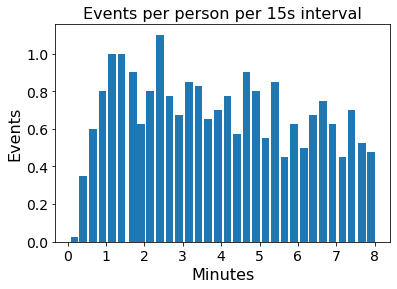

In [39]:
def retrace(game):
    """
    Uses the game log and starting conditions to recreate the state of the
    game at every change event.
    
    Returns a generator yielding (player_id, g, event) at each event in the game,

    *player_id* is the player logging the event,
    *g* is the state of the game following the event,
    *t* timestamp in seconds since game start

    Does not return an action if the only change is a list reordering.
    """
    clues = game['data.clues']
    
    # create trace social network
    edge_list = []
    for player_id, player_data in game['players'].items():
        for alter_id in player_data['data.alterIDs']:
            edge_list.append([player_id, alter_id])
    g = nx.from_edgelist(edge_list)

    # give trace players starting information
    nx.set_node_attributes(
        g,
        name='pos',  # position in the social network
        values={a: game['players'][a]['data.position'] for a in g}
    )

    nx.set_node_attributes(
        g,
        name='M',  # M for mind/memory
        values={a: nx.from_edgelist([
            clues[bf]['nodes'] for bf in
            game['players'][a]['data.initialState']['promising_leads']['clueIDs']
        ]) for a in g}
    )

    nx.set_node_attributes(
        g,
        name='F',  # F for forgetory
        values={i: nx.Graph() for i in g}
    )

    # yield the initial state of the experiment
    yield (None, g, 0)


    # trace game
    t_start = datetime.strptime(game['createdAt'], '%Y-%m-%dT%H:%M:%S.%fZ')

    for event in game['log']:
        if event['name'] != 'drop': # only consider drop events
            continue
            
        player_id = event["playerId"]
        source = event['data']['source']
        dest = event['data']['dest']
        if 'clue' in event['data']:
            if event['data']['clue'] != None:
                edge = clues[event['data']['clue']]['nodes']
            else: # catch incomplete record
                print('Missing clueID for player %s from source %s at time %s' % (player_id, source, event['at']))
        else:
            print('player %s is missing a clue' % player_id)
            continue
        M = g.nodes()[player_id]['M']
        F = g.nodes()[player_id]['F']
        update = False

        if source == "promising_leads":
            assert g.nodes()[player_id]['M'].has_edge(*edge) # check that clue is still in memory
            if dest == "dead_ends":
                M.remove_edge(*edge)
                F.add_edge(*edge)
                update = True

        elif source == "dead_ends":
            assert g.nodes()[player_id]['F'].has_edge(*edge) # check that clue is still in forgettory
            if dest == "promising_leads":
                F.remove_edge(*edge)
                M.add_edge(*edge)
                update = True

        else:
            assert source in game['playerIds']  # check that source is another player
            if not g.nodes()[source]['M'].has_edge(*edge):  # check that clue is in source
                # this can fail if the exposer removes the clue while the exposed is dragging it.
                # turns out not to be a big deal
                print("%s no longer in source %s" % (str(edge), str(source)))
            if dest == "promising_leads":
                M.add_edge(*edge)
                if F.has_edge(*edge):
                    F.remove_edge(*edge)
                update = True
            elif dest == "dead_ends":
                F.add_edge(*edge)
                if M.has_edge(*edge):
                    M.remove_edge(*edge)
                update = True
            assert not (F.has_edge(*edge) and  # not in both memory and forgetery
                        M.has_edge(*edge))

        if update:
            t_current = datetime.strptime(event['createdAt'], '%Y-%m-%dT%H:%M:%S.%fZ')
            t = (t_current - t_start).total_seconds()
            yield (player_id, g, t)

    # double check the final state at the end of the generator
    for player_id in g:
        leads = game['players'][player_id]['data.notebooks']['promising_leads']['clueIDs']
        should_have = set([tuple(sorted(clues[clue]['nodes'])) for clue in leads if clue != None])
        has = set([tuple(sorted(edge)) for edge in g.nodes()[player_id]['M'].edges()])
        assert should_have == has

        deads = game['players'][player_id]['data.notebooks']['dead_ends']['clueIDs']
        should_have = set([tuple(sorted(clues[clue]['nodes'])) for clue in deads if clue != None])
        has = set([tuple(sorted(edge)) for edge in g.nodes()[player_id]['F'].edges()])
        assert should_have == has
       



ts = list(range(0,9*60,15))
events = 0
xs = []
events_list = []

for (player_id, g, t) in retrace(game):
    if t >= ts[0]:
        events_list.append(events)
        xs.append(t)
        ts.pop(0)
    events+=1


plt.bar(xs[1:], np.diff(events_list)/40, width=-12, align='edge')
plt.title("Events per person per 15s interval", fontsize=16)
plt.xlabel("Minutes", fontsize=16)
plt.ylabel("Events", fontsize=16)
plt.xticks(range(0, 481, 60), range(0,9), fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0)